In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, roc_curve, f1_score, auc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

d:\Softwares\anaconda3\envs\projeto-santander\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [2]:
treino = pd.read_csv("train.csv")
teste = pd.read_csv("test.csv")

treino.shape, teste.shape

((4250, 20), (750, 20))

In [5]:
display(treino.head())
display(teste.head())

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [4]:
id_submit = teste["id"]
teste.drop('id', axis=1, inplace=True)

In [6]:
treino.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [7]:
treino.describe(include="O")

,state,area_code,international_plan,voice_mail_plan,churn
count,4250,4250,4250,4250,4250
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,139,2108,3854,3138,3652


In [8]:
# Feature engineering (Criação de 3 novas colunas seguindo o padrão nos dados)

# Treino
treino['total_net_minutes'] = treino['total_day_minutes'] + treino['total_eve_minutes'] + treino['total_night_minutes'] # Soma total de minutos
treino['total_net_calls'] = treino['total_day_calls'] + treino['total_eve_calls'] + treino['total_night_calls'] # Soma do total de chamadas
treino['total_net_charge'] = treino['total_day_charge'] + treino['total_eve_charge'] + treino['total_night_charge'] # Soma total da cobrança

# Teste
teste['total_net_minutes'] = teste['total_day_minutes'] + teste['total_eve_minutes'] + teste['total_night_minutes']
teste['total_net_calls'] = teste['total_day_calls'] + teste['total_eve_calls'] + teste['total_night_calls']
teste['total_net_charge'] = teste['total_day_charge'] + teste['total_eve_charge'] + teste['total_night_charge']

In [9]:
# Codificando as variáveis area_code, international_plan, voice_mail_plan e churn

# Treino
treino['area_code'] = treino['area_code'].apply(lambda x: int(x.split("_")[2]))
treino['international_plan'] = treino['international_plan'].map(dict(yes=1, no=0))
treino['voice_mail_plan'] = treino['voice_mail_plan'].map(dict(yes=1, no=0))
treino['churn'] = treino['churn'].map(dict(yes=1, no=0))

# Teste
teste['area_code'] = teste['area_code'].apply(lambda x: int(x.split("_")[2]))
teste['international_plan'] = teste['international_plan'].map(dict(yes=1, no=0))
teste['voice_mail_plan'] = teste['voice_mail_plan'].map(dict(yes=1, no=0))

In [10]:
# Codificando a variável categórica state

encoder = OrdinalEncoder()
treino["state"] = encoder.fit_transform(treino[["state"]])
teste["state"] = encoder.transform(teste[["state"]])

In [11]:
display(treino.head())
display(teste.head())

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_net_minutes,total_net_calls,total_net_charge
0,35.0,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,611.5,329,55.54
1,31.0,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,527.2,328,59.00
2,35.0,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,558.2,248,65.02
3,36.0,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,501.9,356,49.36
4,19.0,121,510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,779.3,314,76.28


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,total_net_minutes,total_net_calls,total_net_charge
0,16.0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,707.2,300,72.86
1,1.0,118,510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,647.9,317,65.91
2,12.0,62,415,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,630.9,245,55.77
3,46.0,93,510,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,538.5,346,56.80
4,29.0,174,415,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,652.1,303,55.96


In [13]:
# Divisão das variáveis preditoras (X) e da variável target (y)
X = treino.drop("churn", axis=1)
y = treino["churn"]

In [14]:
# Divisão dos dados em Treino e Teste
X_treino, X_valid, y_treino, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
# Visualizando a Variável Target
y_treino.value_counts()

0    2931
1     469
Name: churn, dtype: int64

In [18]:
# Aplicando o balanceamento da classe
print('Antes do balanceamento para o label 0 {}'.format(sum(y_treino==0)))
print('Antes do balanceamento para o label 1 {}'.format(sum(y_treino==1)))

# OverSampling
sampler = RandomOverSampler(random_state=1)
X_treino_sampler, y_treino_sampler = sampler.fit_resample(X_treino, y_treino)
print()

print('Depois do balanceamento para o label 0 {}'.format(sum(y_treino_sampler==0)))
print('Depois do balanceamento para o label 1 {}'.format(sum(y_treino_sampler==1)))

Antes do balanceamento para o label 0 2931
Antes do balanceamento para o label 1 469

Depois do balanceamento para o label 0 2931
Depois do balanceamento para o label 1 2931


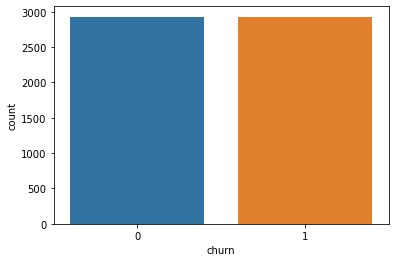

In [19]:
# Gráfico da variável
sns.countplot(x = y_treino_sampler, data = X_treino)
plt.show()

In [20]:
# Alterando a scala dos dados

std = StandardScaler()
mms = MinMaxScaler()
cols = X_treino.columns

# Treino
X_std = std.fit_transform(X_treino_sampler)
X_std = pd.DataFrame(data = X_std, columns = cols)

X_mms = mms.fit_transform(X_treino_sampler)
X_mms = pd.DataFrame(data = X_mms, columns = cols)

# Validação
X_valid_std = std.transform(X_valid)
X_valid_mms = std.transform(X_valid)

In [24]:
# Função para treinamento dos modelos

def Modelos(modelo, nome, d, xtreino, ytreino, xvalid, yvalid):
    print(nome)
    
    clf = modelo
    clf.fit(xtreino, ytreino)
    
    y_pred = clf.predict(xtreino)
    tr_acc = accuracy_score(y_pred, ytreino) * 100
    
    y_pred = clf.predict(xvalid)
    te_acc = accuracy_score(y_pred, yvalid)*100
    
    F1 = f1_score(y_pred, yvalid)
    fpr, tpr, threshould = roc_curve(y_pred, yvalid)
    AUC = auc(fpr, tpr)
    
    d['Nome'].append(nome)
    d['Treino ACU'].append(tr_acc)
    d['Valid ACU'].append(te_acc)
    d['F1'].append(F1)
    d['AUC'].append(AUC)
    
    print("**********"*5)
    print()
    return d

In [25]:
# Treinando os modelos e armazenando os resultados

l = [X_treino_sampler, X_std, X_mms]
final = []
for i in l:
    X_treino, X_valid, y_treino, y_valid = train_test_split(i, y_treino_sampler, test_size = 0.20, random_state = 42)
    
    d = {'Nome' : [], 'Treino ACU': [], 'Valid ACU': [], 'F1': [], 'AUC': []}
    
    modelos = [ 
                [RandomForestClassifier(n_jobs=-1, random_state=42), 'Random Forest'],
                [XGBClassifier(random_state=42), 'XGBoost'], 
                [CatBoostClassifier(task_type="GPU", random_state=42, verbose=False), 'CatBoost'], 
                [LGBMClassifier(n_jobs=-1, random_state=42), 'LGBM']
            ]

    for modelo in modelos:
        d = Modelos(modelo[0], modelo[1], d, X_treino, y_treino, X_valid, y_valid)
    final.append(d)

Random Forest
**************************************************

XGBoost
[15:12:31] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**************************************************

CatBoost
**************************************************

LGBM
**************************************************

Random Forest
**************************************************

XGBoost
[15:13:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**************************************************

CatBoost
*******************************************

In [28]:
# Visualizando a melhor scala com o melhor modelo

name = ['Normal', 'Standard', 'Min Max']
for i in range (len(name)):
    print(name[i])
    acu_data = pd.DataFrame(data = final[i])
    print(acu_data)
    print("******"*10)

Normal
            Nome  Treino ACU  Valid ACU        F1       AUC
0  Random Forest  100.000000  99.488491  0.994801  0.994884
1        XGBoost  100.000000  99.658994  0.996546  0.996558
2       CatBoost   99.765408  99.232737  0.992208  0.992313
3           LGBM  100.000000  99.829497  0.998270  0.998273
************************************************************
Standard
            Nome  Treino ACU  Valid ACU        F1       AUC
0  Random Forest  100.000000  99.488491  0.994801  0.994884
1        XGBoost  100.000000  99.658994  0.996546  0.996558
2       CatBoost   99.765408  99.232737  0.992208  0.992313
3           LGBM  100.000000  99.744246  0.997407  0.997414
************************************************************
Min Max
            Nome  Treino ACU  Valid ACU        F1       AUC
0  Random Forest  100.000000  99.488491  0.994801  0.994884
1        XGBoost  100.000000  99.658994  0.996546  0.996558
2       CatBoost   99.765408  99.232737  0.992208  0.992313
3           LG

In [31]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=42)
lgbm.fit(X_treino_sampler, y_treino_sampler)
y_pred_sub = lgbm.predict(teste)

LGBMClassifier(random_state=42)

In [33]:
submit = pd.DataFrame({"id":id_submit, "churn":y_pred_sub})
submit.head()

,id,churn
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [34]:
# Alterando o label
submit["churn"].replace([0,1],['no','yes'], inplace=True)

In [35]:
submit.to_csv('submission.csv',index=False)